Run first the [setup notebook](./00-setup.ipynb)

# POS and NER tagging of dat

In [1]:

# Project Gutenberg, 244: A Study in Scarlet (en), Arthur Conan Doyle
text_en = """
This was a lofty chamber, lined and littered with countless bottles.
Broad, low tables were scattered about, which bristled with retorts,
test-tubes, and little Bunsen lamps, with their blue flickering flames.
There was only one student in the room, who was bending over a distant
table absorbed in his work. At the sound of our steps he glanced round
and sprang to his feet with a cry of pleasure. “I’ve found it! I’ve
found it,” he shouted to my companion, running towards us with a
test-tube in his hand. “I have found a re-agent which is precipitated
by hæmoglobin, and by nothing else.” Had he discovered a gold mine,
greater delight could not have shone upon his features.
""".strip()

text_en = "The quick brown fox jumps over the lazy dog."

In [3]:
import nltk
import spacy
from transformers import pipeline

nlp_bert = pipeline("token-classification", model="vblagoje/bert-english-uncased-finetuned-pos", aggregation_strategy="max")
nlp_bertweet = pipeline("token-classification", model="TweebankNLP/bertweet-tb2_ewt-pos-tagging", aggregation_strategy="simple")

spacy.prefer_gpu()
nlp_spacy = spacy.load('en_core_web_sm')

Some weights of the model checkpoint at vblagoje/bert-english-uncased-finetuned-pos were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Device set to use cpu


In [4]:
from collections import defaultdict
from pprint import pprint

def add_tokens(lookup: dict, name: str, tagged_tokens: list[tuple[str,str]]):
  for token, tag in tagged_tokens:
    token = token.replace('@@','').lower()
    if not token.isalpha():
      continue
    if not token in lookup:
      lookup[token] = defaultdict(str)
      lookup[token]['token'] = token
    lookup[token][name] = tag

# tagset = None for standard, or tagset = 'universal'
def get_pos_nltk(text: str, tagset: str=None):
  tokens = nltk.word_tokenize(text_en)
  return nltk.pos_tag(tokens, tagset=tagset)

def get_pos_spacy(text: str):
  tokens = nlp_spacy(text)
  return [(token.text, token.pos_) for token in tokens]

def get_pos_bert(text: str):
  tokens = nlp_bert(text)
  return [(token['word'], token['entity_group']) for token in tokens]

def get_pos_bertweet(text: str):
  tokens = nlp_bertweet(text)
  return [(token['word'], token['entity_group']) for token in tokens]


lookup = {}
add_tokens(lookup, 'nltk(standard)', get_pos_nltk(text_en))
add_tokens(lookup, 'nltk(universal)', get_pos_nltk(text_en, 'universal'))
add_tokens(lookup, 'spaCy', get_pos_spacy(text_en))
add_tokens(lookup, 'BERT', get_pos_bert(text_en))
add_tokens(lookup, 'BERTweet', get_pos_bertweet(text_en))


In [5]:
from IPython.display import display, Markdown
from tabulate import tabulate

headers = ['term', 'nltk (pos)', 'nltk (universal)', 'spaCy', 'BERT', 'BERTweet']
rows = []

for e in lookup.values():
  rows.append([e['token'], e['nltk(standard)'],e['nltk(universal)'],e['spaCy'],e['BERT'],e['BERTweet']])
  if len(rows) > 30:
    break

Markdown(tabulate(rows, headers, tablefmt='pipe'))

| term   | nltk (pos)   | nltk (universal)   | spaCy   | BERT   | BERTweet   |
|:-------|:-------------|:-------------------|:--------|:-------|:-----------|
| the    | DT           | DET                | DET     | DET    | DET        |
| quick  | JJ           | ADJ                | ADJ     |        |            |
| brown  | NN           | NOUN               | ADJ     |        |            |
| fox    | NN           | NOUN               | NOUN    | NOUN   | NOUN       |
| jumps  | VBZ          | VERB               | VERB    | VERB   | VERB       |
| over   | IN           | ADP                | ADP     | ADP    | ADP        |
| lazy   | JJ           | ADJ                | ADJ     | ADJ    | ADJ        |
| dog    | NN           | NOUN               | NOUN    | NOUN   | NOUN       |

In [6]:
from helpers import get_book
from collections import Counter

book = get_book(244)

tokens = nltk.word_tokenize(book.page_content)
tagged_tokens = nltk.pos_tag(tokens)
freqs = nltk.FreqDist(tag for (word, tag) in tagged_tokens).most_common(20)
display(Markdown(tabulate(freqs, ["tag (nltk)", "freq"], tablefmt='pipe')))

tagged_tokens = nltk.pos_tag(tokens, tagset="universal")
freqs = nltk.FreqDist(tag for (word, tag) in tagged_tokens).most_common(20)
display(Markdown(tabulate(freqs, ["tag (nltk, universal)", "freq"], tablefmt='pipe')))

tokens = nlp_spacy(book.page_content)
freqs = nltk.FreqDist(t.pos_ for t in tokens).most_common(20)
display(Markdown(tabulate(freqs, ["tag (spaCy)", "freq"], tablefmt='pipe')))


| tag (nltk)   |   freq |
|:-------------|-------:|
| NN           |   6906 |
| IN           |   5602 |
| DT           |   4620 |
| PRP          |   4031 |
| VBD          |   3459 |
| JJ           |   3070 |
| ,            |   2959 |
| NNP          |   2558 |
| .            |   2433 |
| RB           |   2171 |
| CC           |   1786 |
| VB           |   1730 |
| NNS          |   1470 |
| PRP$         |   1358 |
| VBN          |   1233 |
| TO           |   1081 |
| VBP          |    881 |
| VBG          |    709 |
| VBZ          |    678 |
| MD           |    602 |

| tag (nltk, universal)   |   freq |
|:------------------------|-------:|
| NOUN                    |  10953 |
| VERB                    |   9292 |
| PRON                    |   5653 |
| ADP                     |   5602 |
| .                       |   5550 |
| DET                     |   5260 |
| ADJ                     |   3234 |
| ADV                     |   2520 |
| CONJ                    |   1786 |
| PRT                     |   1359 |
| NUM                     |    345 |
| X                       |     49 |

| tag (spaCy)   |   freq |
|:--------------|-------:|
| PUNCT         |   8086 |
| NOUN          |   7467 |
| PRON          |   6759 |
| VERB          |   6019 |
| ADP           |   5074 |
| DET           |   4443 |
| SPACE         |   3844 |
| AUX           |   3064 |
| ADJ           |   2854 |
| ADV           |   2266 |
| CCONJ         |   1702 |
| PROPN         |   1609 |
| SCONJ         |   1446 |
| PART          |    973 |
| NUM           |    403 |
| INTJ          |     84 |
| X             |     16 |
| SYM           |      1 |

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


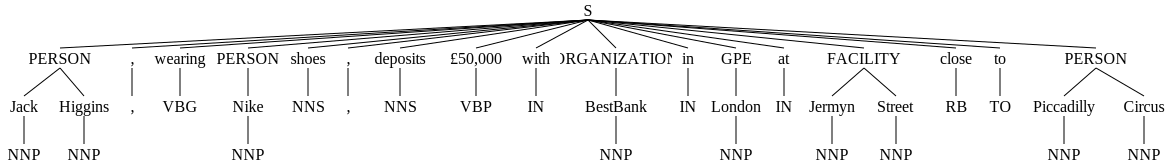

In [7]:
text_ner = "Jack Higgins, wearing Nike shoes, deposits £50,000 with BestBank in London at Jermyn Street close to Piccadilly Circus"
nlp_bert = pipeline("ner", model="dslim/bert-base-NER", aggregation_strategy="max")

def add_tokens(lookup: dict, name: str, tagged_tokens: list[tuple[str,str]]):
  for token, tag in tagged_tokens:
    if not token in lookup:
      lookup[token] = defaultdict(str)
      lookup[token]['token'] = token
    lookup[token][name] = tag

def get_ner_nltk(text: str):
  tokens = nltk.word_tokenize(text)
  tagged_tokens = nltk.pos_tag(tokens)
  display(nltk.ne_chunk(tagged_tokens))
  ner_chunks = [chunk for chunk in nltk.ne_chunk(tagged_tokens) if hasattr(chunk,'label')]
  return [(' '.join(c[0] for c in chunk), chunk.label()) for chunk in ner_chunks]

def get_ner_spacy(text: str):
  tokens = nlp_spacy(text).ents
  return [(t.text, t.label_) for t in tokens]

def get_ner_bert(text: str):
  tokens = nlp_bert(text_ner)
  return [(t['word'], t['entity_group']) for t in tokens]

lookup = {}
add_tokens(lookup, 'nltk', get_ner_nltk(text_ner))
add_tokens(lookup, 'spaCy', get_ner_spacy(text_ner))
add_tokens(lookup, 'BERT', get_ner_bert(text_ner))

In [8]:
headers = ['term', 'nltk', 'spaCy', 'BERT']
rows = []

for e in lookup.values():
  rows.append([e['token'], e['nltk'],e['spaCy'],e['BERT']])
  if len(rows) > 30:
    break
rows.sort()
Markdown(tabulate(rows, headers, tablefmt='pipe'))

| term              | nltk         | spaCy   | BERT   |
|:------------------|:-------------|:--------|:-------|
| 50,000            |              | MONEY   |        |
| BestBank          | ORGANIZATION | ORG     | ORG    |
| Jack Higgins      | PERSON       | PERSON  | PER    |
| Jermyn Street     | FACILITY     | FAC     | LOC    |
| London            | GPE          | GPE     | LOC    |
| Nike              | PERSON       | ORG     | MISC   |
| Piccadilly Circus | PERSON       | ORG     | LOC    |

---